---
title: "Home Credit Default Risk Analysis (Sampled Data)"
---

## Objective 
This notebook develops a baseline model using a variety of models on a sampled subset of the Home Credit Default Risk dataset. The primary goal is to predict the likelihood that a loan applicant will experience payment difficulties, using historical credit, demographic, and behavioral features. 

## Dataset 
This analysis uses a downsampled version of the original datasets for rapid iteration and model tuning. 
All preprocessing steps and model logic will mirror the full dataset pipeline with appropriate adaptions (included as a separate notebook), enabling easy transfer. 
All datasets are merged into one dataset on the loan / applicant level using the key `SKI_ID_CURR` (or `SK_ID_PREV`, which merges into datasets that have `SK_ID_CURR`, which then merge into one dataset.) 
All time-series features are aggregated to enable their usefulness. 

- Each row: one loan application ('SK_ID_CURR')
- `TARGET = 1`: client had significant payment issues
- `TARGET = 0`: client repaid as expected

## Models tested
- Logistic Regression: used as a baseline to compare other, more complex models 
- Random Forest: captures nonlinear relationships and reduces overfitting through bagging
- XGBoost: scalable gradient boosting method
- CatBoost: optimized for handling categorical variables natively
- LightGBM: fast and efficient with large datasets

This dataset, comprised of several base tables, is very large, spanning millions of rows and hundreds of features. This necessitates using a model that can handle a large number of complex features to successfully complete a classification task.

## Evaluation metric 
The primary metric is AUC_ROC, with secondary attention to Recall, due to the cost of missing high-risk clients. Threshold optimization will be explored. 

## Notebook Outline
1. Load and sample datasets
2. Encode, aggregate, and merge
3. Preprocessing
4. Modeling
5. Model selection
6. Feature engineering
7. Final model
8. Conclusion


# Section 1: Load and sample datasets
***

## 1.1 Import statements

In [ ]:
# Standard library
import contextlib
import io
import os
import sys
import warnings


# Core numerical / data libraries
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


# Scikit-learn: preprocessing, metrics, model selection
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler


# Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


# Explainability
import shap


# Hyper-parameter optimisation
import optuna
from optuna.pruners import SuccessiveHalvingPruner


# Global noise / log filters
warnings.filterwarnings("ignore")                          # silence all Python warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

optuna.logging.disable_default_handler()                   # detach Optuna’s stdout handler
optuna.logging.set_verbosity(optuna.logging.WARNING)       # keep only WARNING+

## 1.2 Load and sample datasets 
- To facilitate for efficient development and model testing, this notebook uses a sampled subset of of the full Home Credit Default Risk dataaset to assess techniques that will be applied to the original dataset in the next notebook.  

### Data Integration
The main dataset is `application_train.csv`, which contains one row per loan application and the `TARGET` variable. To enrich this data, relational joins are made between several secondary tables using `SK_ID_CURR` or `SK_ID_PREV` as appropriate. 

- `bureau.csv` and `bureau_balance.csv`: previous credit hitory from other institutions
- `previous_application.csv`: prior loan applications with Home Credit 
- `installments_payments.csv`: repayment history 
- `credit_card_balance.csv`: monthly credit card activity 
- `POS_CASH_balance.csv`: point-of-sale and cash loan snapshots

For each auxiliary table: 
- We aggregate features by `SK_ID_CURR` using summary statistics (mean, max, std, count, sum).
- This results in one row per loan in the final joined dataset while preserving alignment with the target variable. 

### Sampling strategy 
- A sample taken, comprising of 10-20% of the original datasets, using stratification to maintain the original class imbalance and ensure that the minority class (`TARGET=1`) is properly represented. 

## 1.2 Initial load of main table 
- `application_train.csv` is what the other tables will eventually be merged into. 
- There are over 300k rows, and 121 features (minus the target variable) that will need consideration. 

In [2]:
# Load main data table
app = pd.read_csv("../data/application_train.csv")

# Inspection function
def inspect(df, name="DataFrame"):
    print(f"\n{name} shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nInfo:")
    print(df.info())
    print("\nPreview")
    display(df.head())

inspect(app, "Application Train")


Application Train shape: (307511, 122)

Columns:
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATI

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.3 Sample of `application_train.csv`
- 10% of this data is sampled into `app_sample` and the sampled dataset is saved as a .csv file to enable merging. 

In [3]:
# Take 10% sample 
app_sample = app.sample(frac=0.1, random_state=42)

# Save to CSV
app_sample.to_csv("../data/sample_application_train.csv", index=False)

## 1.4 Sample of `bureau.csv`
- `bureau.csv` is filtered to keep only rows that have `SK_ID_CURR` in the sample set `bureau_sample`, which is saved to .csv. 
- Filtering this way ensures that only credit bureau records that pertain to applicants sampled in `application_train` will be included in the analysis. 

In [ ]:
#| output: false
# Load and inspect bureau.csv
bureau = pd.read_csv("../data/bureau.csv")
inspect(bureau, "Bureau")

# Filter to keep only rows that have SK_ID_CURR
bureau_sample = bureau[bureau['SK_ID_CURR'].isin(app_sample['SK_ID_CURR'])]

# Save sample to CSV
bureau_sample.to_csv("../data/sample_bureau.csv", index=False)


Bureau shape: (1716428, 17)

Columns:
['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_D

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## 1.5 Sample of `bureau_balance.csv`
- `bureau_balance.csv` filtered again, this time to keep only rows that have values for `SK_ID_BUREAU`, which is the shared key between this file and `bureau.csv`. This enables merging the tables later. 

In [ ]:
#| output: false
# Load and inspect bureau_balance.csv
bureau_bal = pd.read_csv("../data/bureau_balance.csv")
inspect(bureau_bal, "Bureau_Balance")

# Filter to only keep rows with SK_ID_BUREAU
bureau_bal_sample = bureau_bal[bureau_bal['SK_ID_BUREAU'].isin(bureau_sample['SK_ID_BUREAU'])]

# Save sample to CSV 
bureau_bal_sample.to_csv("../data/sample_bureau_balance.csv", index=False)


Bureau_Balance shape: (27299925, 3)

Columns:
['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None

Preview


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## 1.6 Sample of `previous_application.csv`
- Filtered to keep only rows with `SK_ID_CURR`, which will be the joining column for the final table.

In [ ]:
#| output: false
# Load and inspect previous_application
prev_app = pd.read_csv("../data/previous_application.csv")
inspect(prev_app, "Previous Application")

# Filter to keep rows with SK_ID_CURR and save sample to CSV 
prev_sample = prev_app[prev_app['SK_ID_CURR'].isin(app_sample['SK_ID_CURR'])]
prev_sample.to_csv("../data/sample_previous_application.csv", index=False)


Previous Application shape: (1670214, 37)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## 1.7 Sample of `POS_cash_balance.csv`
- This table shares `SK_ID_PREV` with with `previous_applications.csv`, so we filter only for rows that have this key for later merging. 

In [ ]:
#| output: false
# Load and inspect POS_CASH_balance
pos_cash = pd.read_csv("../data/POS_CASH_balance.csv")
inspect(pos_cash, "POS_CASH Balance")

# Filter by SK_ID_PREV (shared with previous_applications) and save sample to CSV
pos_cash_sample = pos_cash[pos_cash['SK_ID_PREV'].isin(prev_sample['SK_ID_PREV'])]
pos_cash_sample.to_csv("../data/sample_pos_cash_balance.csv", index=False)


POS_CASH Balance shape: (10001358, 8)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None

Preview


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


## 1.8 Sample of `installments_payments.csv`
- This table also shares `SK_ID_PREV` with with `previous_applications.csv`, so I filter only for rows that have this key for later merging. 

In [ ]:
#| output: false
# Load and inspect installments_payments
installments = pd.read_csv("../data/installments_payments.csv")
inspect(installments, "Installments Payments")

# Filter to keep SK_ID_PREV rows (shared with previous_installments) / save sample to CSV
installments_sample = installments[installments['SK_ID_PREV'].isin(prev_sample['SK_ID_PREV'])]
installments_sample.to_csv("../data/sample_installments_payments.csv", index=False)


Installments Payments shape: (13605401, 8)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None

Preview


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## 1.9 Sample of `credit_card_balance.csv`
- This table also shares `SK_ID_PREV` with with `previous_applications.csv`, so I filter only for rows that have this key for later merging. 

In [ ]:
#| output: false
# Loand and inspect credit_card_balance
cc_bal = pd.read_csv("../data/credit_card_balance.csv")
inspect(cc_bal, "Credit Card Balance")

# Filter to keep SK_ID_PREV rows (shared with previous_applications) / save sample to CSV 
cc_sample = cc_bal[cc_bal['SK_ID_PREV'].isin(prev_sample['SK_ID_PREV'])]
cc_sample.to_csv("../data/sample_credit_card_balance.csv", index=False)


Credit Card Balance shape: (3840312, 23)

Columns:
['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AM

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


# Section 2: Encode, aggregate, and merge
***
- One-Hot encoding is used (as opposed to LabelEncoder or OrdinalEncoder) because it is the most appropriate method for encoding nominal variables. Other methods would introduce a false sense of order among the classes. 

## 2.1 Load samples 
- Store sampled datasets into variables for merging. 

In [10]:
# Create variables to hold sampled datasets 
app_sample = pd.read_csv("../data/sample_application_train.csv")
bureau_sample = pd.read_csv("../data/sample_bureau.csv")
bureau_bal_sample = pd.read_csv("../data/sample_bureau_balance.csv")

## 2.2 Encode and aggregate `bureau_bal_sample`
- `STATUS` is appropriate for one-hot encoding since it has low dimensionality and is potentially predictive of the target variable. 
  - It contains categorical credit status codes (`0`, `1`, ..., `5`, `C`, `X`) indicating the repayment behavior of each loan over time. 
  - It is then aggregated by `SK_ID_BUREAU` to ensure one row per key. 
  - The mean is used here to summarize each applicant's monthly repayment behavior (for example: `1.0` IN `STATUS_0` means credit was always current, while `0.5` means it was current in half of the recorded months).
- Columns are prepended with `BB_` to indicate that they originated from the `bureau_balance` table to improve traceablility during feature engineering. 
- The index of bureau_bal_agg is reset so that SK_ID_BUREAU turns back into a regular column rather than a DataFrame index (which it became after the aggregation). This enables merging in the next step. 

In [11]:
# One-hot encode STATUS column
bureau_bal_encoded = pd.get_dummies(bureau_bal_sample, columns=["STATUS"])

# Aggregate repayment behavior across months per credit line (SK_ID_BUREAU)
bureau_bal_agg = bureau_bal_encoded.groupby("SK_ID_BUREAU").agg("mean")

# Prepend BB_ to aggregated columns
bureau_bal_agg.columns = [f"BB_{col}" for col in bureau_bal_agg.columns]

# Enable merge on SK_ID_BUREAU in the following step
bureau_bal_agg.reset_index(inplace=True)

## 2.3 Merge `bureau_bal_sample` with `bureau_sample` into `bureau_merged`
- Their shared key is `SK_ID_BUREAU`, which represents individual previous credit card accounts. 
- The resulting table `bureau_merged` still contains multiple rows for `SK_ID_CURR`, which will be fixed by aggregating to this key. 

In [12]:
bureau_merged = bureau_sample.merge(bureau_bal_agg, on="SK_ID_BUREAU", how="left")

## 2.4 Encode and aggregate `bureau_merged` into `bureau_agg`
- First, `bureau_merged` features `CREDIT_ACTIVE` AND `CREDIT_TYPE` are one-hot encoded. 
  - `CREDIT_ACTIVE`: Current status of a credit line at the time of loan application. 
    - Classes: ["Active", "Closed", "Sold", "Bad debt"]
    - This is a strong indicator of financial responsibility:
      - Active accounts could mean that the client has increased financial obligations which may signal risk. 
      - Closed accounts indicate that their loans have been fully repaid, which is positive evidence of financial responsibility. 
      - Sold / Bad debt / Charged off values may indicate that the lender offloaded the account due to deliquency, a potential red flag. 
  - `CREDIT_TYPE`: Type of credit product associated with each SK_ID_BUREAU.
    - Classes (common occurrences): ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan", "Loan for business development / working capital replinishment"]
    - This feature provides context into financial behaviors: 
      - Clients with many credit cards may carry more short term debt, which indicates higher risk for a long-term home loan. 
      - Presence of mortages suggest that the corresponding clients have a higher income / higher ability to satisfy loan requirements. 
- Boolean columns are included because, when averaged, these  columns represent the proportion of credit lines matching each condition — for example: the percentage of a client’s previous credits that are still active, or that were mortgages.
- `BUREAU_` is prepended to aggregated columns for traceability.

In [13]:
# One-hot encode CREDIT_ACTIVE and CREDIT_TYPE
bureau_merged = pd.get_dummies(bureau_merged, columns=["CREDIT_ACTIVE", "CREDIT_TYPE"], dummy_na=True)

# Bool types are included to include encoding of possible values of ["True" / "False" / "Yes" / "No" / etc.] in those columns
bureau_numeric = bureau_merged.select_dtypes(include=['number', 'bool'])

# Aggregation over one-hot encoded boolean columns:
# - .mean() gives the proportion of credit lines per client matching each category
# - .sum() gives raw counts of how often each condition occurred
# - Useful for understanding frequency and diversity of credit behavior
bureau_agg = bureau_numeric.groupby("SK_ID_CURR").agg(["mean", "max", "min", "std", "sum"])

# Prepend BUREAU_ to show where the columns came from
bureau_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_agg.columns]

## 2.5 Merge `bureau_agg` with `app_sample` into `app_with_bureau`
- Now that `bureau_agg` is aggregated such that it has only one row per `SK_ID_CURR`, it can now be merged with the main table `app_sample`.
- `app_sample` is renamed to `app_with_bureau`, and will be renamed with each merge to clarify what it contains at each merging step. 

In [14]:
# Merge bureau with main table
app_with_bureau = app_sample.merge(bureau_agg, on="SK_ID_CURR", how="left")

## 2.6 Load and encode `sample_previous_application`
- This table will eventually be merged alongside `POS_CASH_balance`, `installments_payments`, and `credit_card_balance` to enrich the `app_sample` records.
- One-hot encoding is applied here to categorical variables so that downstream models (LightGBM, XGBoost, Logistic Regression) can interpret them numerically.

In [15]:
# Load sample_previous_application
prev = pd.read_csv("../data/sample_previous_application.csv")

# One-hot encode categorical columns
prev_encoded = pd.get_dummies(prev, columns=["NAME_CONTRACT_STATUS", "NAME_PRODUCT_TYPE", "NAME_CLIENT_TYPE", "NAME_CONTRACT_TYPE", "NAME_PAYMENT_TYPE"], dummy_na=True)

## 2.7 Aggregate numeric columns into `prev_agg`
- Since one column per `SK_ID_CURR` is needed, aggregate values of numerical and bool types (for reasons described above) are taken to facilitate this. 

In [16]:
# Get numerical and boolean columns
prev_numeric = prev_encoded.select_dtypes(include=["number", "bool"])

# Obtain aggregates - result is one row per SK_ID_CURR
prev_agg = prev_numeric.groupby("SK_ID_CURR").agg(["mean", "max", "min", "std", "sum"])

# Append `PREVAPP_` for traceability
prev_agg.columns = ["PREVAPP_" + "_".join(col).upper() for col in prev_agg.columns]

# Facilitate merge into main table 
prev_agg.reset_index(inplace=True)

## 2.8 Merge sampled `previous_application` with main table on `SK_ID_CURR`

In [17]:
# Main table renamed for clarity
app_with_bureau_prev = app_with_bureau.merge(prev_agg, on="SK_ID_CURR", how="left")

## 2.9 Load sampled `POS_CASH_balance `
- Will be merged with sampled `previous_application` on SK_ID_PREV

In [18]:
pos = pd.read_csv("../data/sample_pos_cash_balance.csv")

## 2.10 Aggregate numerical features from sampled `POS_CASH_balance`
- Summary of repayment activity for each loan (past loans with Home Credit)
- Features are grouped by `SK_ID_PREV` (one row per loan) and summary statistics are computed:
  - `MONTHS_BALANCE`: how far back the record goes (`min`, `max`) and how many months are recorded (`count`)
  - `SK_DPD`, `SK_DPD_DEF`: days past due / chronic delinquency
  - `CNT_INSTALMENT`: total scheduled installments
  - `CNT_INSTALMENT_FUTURE`: number of remaining scheduled installments on the loan at the time of observation

In [19]:
# Ensure one row per SK_ID_PREV
pos_agg_by_loan = pos.groupby("SK_ID_PREV").agg({
    "MONTHS_BALANCE": ["min", "max", "count"],
    "SK_DPD": ["mean", "max"],
    "SK_DPD_DEF": ["mean", "max"],
    "CNT_INSTALMENT": ["mean", "max", "min"],
    "CNT_INSTALMENT_FUTURE": ["mean", "max", "min"]
})

# Prepend with POS_ to identify where tables came from 
pos_agg_by_loan.columns = ["POS_" + "_".join(col).upper() for col in pos_agg_by_loan.columns]

# Facilitate merge
pos_agg_by_loan.reset_index(inplace=True)

## 2.11 Merge sampled and aggregated `POS_CASH_balance` with sampled `previous_application` on `SK_ID_PREV`	
- `SK_ID_PREV` is shared by these two columns, and both that key and `SK_ID_CURR` are present in `prev`, so this is a precursor to a merge with the main table. 
- There are still multiple `SK_ID_PREV` values per `SK_ID_CURR`, so and second aggregation (mean) is taken to consolidate columns while retaining information. 
- `SK_ID_PREV` is now redundant and is dropped.
- Sampled `POS_CASH_balance` is merged with the main table, and main table is renamed for clarity. 

In [20]:
# Merge with sampled previous_application
pos_with_curr = pos_agg_by_loan.merge(prev[["SK_ID_PREV", "SK_ID_CURR"]], on="SK_ID_PREV", how="left")

In [21]:
# Drop SK_ID_PREV
pos_final = pos_with_curr.drop(columns=["SK_ID_PREV"]).groupby("SK_ID_CURR").agg("mean")

# Facilitate merge
pos_final.reset_index(inplace=True)

In [22]:
# Merge with main table and rename 
app_with_pos = app_with_bureau_prev.merge(pos_final, on="SK_ID_CURR", how="left")

## 2.12 Load sampled `installments_payments`

In [23]:
inst = pd.read_csv("../data/sample_installments_payments.csv")

## 2.13 Required feature engineering
- New features are created for `installments_payments` to illustrate repayment behavior relative to scheduled payment plans. 
  - These features provide insight into timeliness and consistency in past repayment history, which is presumably predictive of credit risk. 
- New features: 
  - `PAYMENT_DIFF_DAYS`: Difference between actual payment date and scheduled payment date. Positive values = late payments; Negative values = early payments. 
  - `PAYMENT_RATIO`: Ratio of actual amount paid to scheduled installment amount. Values > 1 = overpayment; Values < 1 = underpayment. 
  - `PAYMENT_DIFF_AMT`: Difference between amount paid and expected amount. Positive = overpayment; Negative = underpayment. 
- Numerical features from `installments_payments` are then aggregated in same manner as previous tables. 
- This table is first merged with the `SK_ID_PREV` and `SK_ID_CURR` columns of `previous_application` on `SK_ID_PREV`, which facilitates a later merge with sampled `application_train`

In [24]:
# Engineer new features 
inst["PAYMENT_DIFF_DAYS"] = inst["DAYS_ENTRY_PAYMENT"] - inst["DAYS_INSTALMENT"]
inst["PAYMENT_RATIO"] = inst["AMT_PAYMENT"] / inst["AMT_INSTALMENT"]
inst["PAYMENT_DIFF_AMT"] = inst["AMT_PAYMENT"] - inst["AMT_INSTALMENT"]

In [25]:
# Aggregate numeric features to ensure one row per SK_ID_PREV
inst_agg_by_loan = inst.groupby("SK_ID_PREV").agg({
    "PAYMENT_DIFF_DAYS": ["mean", "min", "max"],
    "PAYMENT_RATIO": ["mean", "min", "max"],
    "PAYMENT_DIFF_AMT": ["mean", "min", "max"],
    "AMT_PAYMENT": ["sum"],
    "AMT_INSTALMENT": ["sum"],
    "DAYS_ENTRY_PAYMENT": ["max"],
    "DAYS_INSTALMENT": ["max"]
})

In [26]:
# Prepend INSTALL_ to identify where columns came from 
inst_agg_by_loan.columns = ["INSTALL_" + "_".join(col).upper() for col in inst_agg_by_loan.columns]

# Facilitate merge
inst_agg_by_loan.reset_index(inplace=True)

In [27]:
# Merge with sampled previous_application on SK_ID_PREV - multiple SK_ID_PREV values associated with each SK_ID_CURR
inst_with_curr = inst_agg_by_loan.merge(prev[["SK_ID_PREV", "SK_ID_CURR"]], on="SK_ID_PREV", how="left")

In [28]:
# Consolidate columns by averaging so that there is one row per SK_ID_CURR / drop now-redundant SK_ID_PREV
inst_final = inst_with_curr.drop(columns=["SK_ID_PREV"]).groupby("SK_ID_CURR").agg("mean")

# Facilitate merge into main table 
inst_final.reset_index(inplace=True)

In [29]:
# Merge with main table and rename for clarity
app_with_inst = app_with_pos.merge(inst_final, on="SK_ID_CURR", how="left")

## 2.14 Load sampled `credit_card_balance`

In [30]:
# Load sampled credit_card_balance 
cc = pd.read_csv("../data/sample_credit_card_balance.csv")

## 2.15 Aggregate time-based features from `credit_card_balance` on `SK_ID_PREV`, merge with `previous_application`, merge with main table 
- Summarizes clients' historical credit card behavior by aggregating monthly balance snapshots per previous credit line (`SK_ID_PREV`)
- One row per previous credit card (later aggregated by application)
- Aggregations:
  - `MONTHS_BALANCE`: information about how long client has had these credit lines
  - `AMT_BALANCE`, `AMT_TOTAL_RECEIVABLE`: outstanding balances 
  - `AMT_CREDIT_LIMIT_ACTUAL`: typical credit limit given 
  - `AMT_DRAWINGS`, `CNT_DRAWINGS`: how much / how often client withdrew and spent with credit card
  - `CNT_INSTALMENT_MATURE_CUM`: number of fully paid installments (strong indicator of target)
  - `SK_DPD`, `SK_DPD_DEF`: days past due (DPD) - repayment risk 

In [31]:
# Aggregate time-based features 
cc_agg_by_card = cc.groupby("SK_ID_PREV").agg({
    "MONTHS_BALANCE": ["min", "max", "count"],
    "AMT_BALANCE": ["mean", "max"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean"],
    "AMT_DRAWINGS_ATM_CURRENT": ["mean", "sum"],
    "AMT_DRAWINGS_CURRENT": ["mean", "sum"],
    "AMT_PAYMENT_CURRENT": ["mean", "sum"],
    "AMT_TOTAL_RECEIVABLE": ["mean", "max"],
    "SK_DPD": ["mean", "max"],
    "SK_DPD_DEF": ["mean", "max"],
    "CNT_DRAWINGS_CURRENT": ["mean", "sum"],
    "CNT_INSTALMENT_MATURE_CUM": ["max"],
    "CNT_DRAWINGS_OTHER_CURRENT": ["mean"] 
})

In [32]:
# Prepend with CC_ for traceability
cc_agg_by_card.columns = ["CC_" + "_".join(col).upper() for col in cc_agg_by_card.columns]

# Facilitate merge
cc_agg_by_card.reset_index(inplace=True)

In [33]:
# Merge with sampled previous_application on SK_ID_PREV
cc_with_curr = cc_agg_by_card.merge(prev[["SK_ID_PREV", "SK_ID_CURR"]], on="SK_ID_PREV", how="left")

In [34]:
# Consolidate to one row per SK_ID_CURR by averaging values / drop now-redundant SK_ID_PREV
cc_final = cc_with_curr.drop(columns=["SK_ID_PREV"]).groupby("SK_ID_CURR").agg("mean")

# Facilitate merge 
cc_final.reset_index(inplace=True)

## 2.16 Final (sampled) table 

In [35]:
# app_final now contains all relevant features from all tables 
app_final = app_with_inst.merge(cc_final, on="SK_ID_CURR", how="left")

# Section 3: Preprocessing
***
This section prepares the final dataset (`app_final`) for modeling by conducting a series of sanity checks, column transformations, and imputations.

## 3.1 Initial checks and cleanup 
- Copy of `all_final` is made
- Nulls are inspected 

In [36]:
df = app_final.copy()

# Just for initial check - no split yet 
df.drop(columns=['SK_ID_CURR', 'TARGET'], inplace=True)

# Get top 30 columns with highest ratio of nulls
null_summary = pd.DataFrame({
    'dtype': df.dtypes,
    'null_count': df.isnull().sum(),
    'null_ratio': df.isnull().mean(),
    'n_unique': df.nunique()
}).sort_values(by='null_ratio', ascending=False)

null_summary.head(30)

,dtype,null_count,null_ratio,n_unique
PREVAPP_RATE_INTEREST_PRIVILEGED_STD,float64,30734,0.999447,8
PREVAPP_RATE_INTEREST_PRIMARY_STD,float64,30734,0.999447,14
PREVAPP_RATE_INTEREST_PRIMARY_MEAN,float64,30330,0.986309,52
PREVAPP_RATE_INTEREST_PRIVILEGED_MEAN,float64,30330,0.986309,21
PREVAPP_RATE_INTEREST_PRIVILEGED_MAX,float64,30330,0.986309,14
PREVAPP_RATE_INTEREST_PRIVILEGED_MIN,float64,30330,0.986309,14
PREVAPP_RATE_INTEREST_PRIMARY_MIN,float64,30330,0.986309,41
PREVAPP_RATE_INTEREST_PRIMARY_MAX,float64,30330,0.986309,42
CC_AMT_PAYMENT_CURRENT_MEAN,float64,25555,0.831030,5039
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,float64,25526,0.830087,3213


## 3.2 Drop columns with nulls > 95% 
- These columns are likely to introduce noise into modeling and are thus dropped. 

In [37]:
# Reassign df to be a working copy of the final sampled dataset 
df = app_final.copy()

# Columns with more than 95% null values 
drop_cols = [
    'PREVAPP_RATE_INTEREST_PRIVILEGED_STD',
    'PREVAPP_RATE_INTEREST_PRIMARY_STD',
    'PREVAPP_RATE_INTEREST_PRIMARY_MEAN',
    'PREVAPP_RATE_INTEREST_PRIVILEGED_MEAN',
    'PREVAPP_RATE_INTEREST_PRIVILEGED_MAX',
    'PREVAPP_RATE_INTEREST_PRIVILEGED_MIN',
    'PREVAPP_RATE_INTEREST_PRIMARY_MIN',
    'PREVAPP_RATE_INTEREST_PRIMARY_MAX'
]
    
df.drop(columns=drop_cols, inplace=True)  

## 3.3 Outlier clipping

To reduce the impact of extreme values without removing valuable training data, this step applies winzorization to all numeric features.  

- The top and bottom 1% of values in each column are clipped to reduce skew and stabilize model training.
- This approach is more appropriate than row deletion for large, high-dimensional datasets where some outliers may carry signal.


In [38]:
# Winsorize all numeric feature columns (excluding 'TARGET')
numeric_cols = df.select_dtypes(include=["number"]).columns.drop("TARGET")

for col in numeric_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01]).data

## 3.4 Data splits

This section performs the initial split between features (`X`) and target (`y`) in preparation for modeling. Additional preprocessing is applied to ensure that all features are numeric and model-compatible:

- `SK_ID_CURR` (identifier) and `TARGET` (label) are dropped from `X`, and `TARGET` is assigned to `y`.
- Columns stored as `object` type are encoded to numeric where possible.
- Remaining `object` columns (true categoricals) are one-hot encoded using `pd.get_dummies()` to ensure compatibility with all models, including those that do not support categorical features natively.
- `dummy_na=True` ensures that missing categorical values are explicitly handled and represented as separate dummy variables.

In [39]:
# Separate target and features
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

# Try to convert object columns to numeric
for col in X.select_dtypes(include='object').columns:
    try:
        X[col] = pd.to_numeric(X[col])
    except ValueError:
        pass

# Identify remaining categorical (non-numeric) columns
non_numeric_cols = X.select_dtypes(include='object').columns

# One-hot encode remaining object columns
X = pd.get_dummies(X, columns=non_numeric_cols, dummy_na=True)

## 3.5 Impute nulls with zero or median

This step handles applies two different imputation methods based on the meaning of each feature:

- Zero imputation is applied to aggregated features originating from time-series or transactional data (e.g., `CC_`, `POS_`, `INSTALL_`, `BUREAU_`, `PREVAPP_`).  
  - These missing values typically indicate an absence of activity, so filling them with 0 is both safe and meaningful.
- Median imputation is used for all remaining features.  
  - This helps preserve the overall distribution of each feature while minimizing the influence of extreme values. 


In [40]:
# Identify aggregated features by prefix
zero_impute_cols = [col for col in X.columns if col.startswith(('CC_', 'POS_', 'INSTALL_', 'BUREAU_', 'PREVAPP_'))]

# All other columns
median_impute_cols = [col for col in X.columns if col not in zero_impute_cols]

# Impute zero for aggregated features 
imputer_zero = SimpleImputer(strategy='constant', fill_value=0)

# Impute median for all other features 
imputer_median = SimpleImputer(strategy='median')

# Apply to X
X_zero = pd.DataFrame(imputer_zero.fit_transform(X[zero_impute_cols]), columns=zero_impute_cols, index=X.index)
X_median = pd.DataFrame(imputer_median.fit_transform(X[median_impute_cols]), columns=median_impute_cols, index=X.index)

X_clean = pd.concat([X_zero, X_median], axis=1)[X.columns]

In [41]:
# Sanity check 
X_clean.shape[0] == y.shape[0]  
X_clean.index.equals(y.index)   

True

## 3.6 Train/val/test splits
- Data is split 60/20/20, with both scaled and unscaled versions for the various models that will be tested. 
- Indexes between scaled and unscaled sets are aligned.

In [42]:
# Scale the full cleaned dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_clean), columns=X_clean.columns, index=X_clean.index)

# First split: Train+Val vs. Test
X_temp_unscaled, X_test_unscaled, y_temp, y_test = train_test_split(
    X_clean, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: Train vs. Validation (from Train+Val)
X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(
    X_temp_unscaled, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
# Note: 0.25 of 0.8 = 0.2 → final split is 60% train / 20% val / 20% test

# Use index alignment to get scaled sets
X_train_scaled = X_scaled.loc[X_train_unscaled.index]
X_val_scaled = X_scaled.loc[X_val_unscaled.index]
X_test_scaled = X_scaled.loc[X_test_unscaled.index]


# Section 4: Modeling
***

## 4.1 Logistic Regression
- Performance baseline using logistic regression on scaled features. 
- Threshold tuning is applied to ensure optimal results. Further refinement is reserved for the following models. 

Threshold: 0.05 | Precision: 0.087 | Recall: 0.978 | F1: 0.159
Threshold: 0.10 | Precision: 0.093 | Recall: 0.950 | F1: 0.170
Threshold: 0.15 | Precision: 0.100 | Recall: 0.915 | F1: 0.180
Threshold: 0.20 | Precision: 0.108 | Recall: 0.877 | F1: 0.192
Threshold: 0.25 | Precision: 0.117 | Recall: 0.847 | F1: 0.206
Threshold: 0.30 | Precision: 0.125 | Recall: 0.802 | F1: 0.217
Threshold: 0.35 | Precision: 0.135 | Recall: 0.764 | F1: 0.230
Threshold: 0.40 | Precision: 0.142 | Recall: 0.706 | F1: 0.237
Threshold: 0.45 | Precision: 0.154 | Recall: 0.655 | F1: 0.249
Threshold: 0.50 | Precision: 0.166 | Recall: 0.605 | F1: 0.260
Threshold: 0.55 | Precision: 0.180 | Recall: 0.560 | F1: 0.273
Threshold: 0.60 | Precision: 0.195 | Recall: 0.510 | F1: 0.283
Threshold: 0.65 | Precision: 0.210 | Recall: 0.446 | F1: 0.286
Threshold: 0.70 | Precision: 0.228 | Recall: 0.379 | F1: 0.284
Threshold: 0.75 | Precision: 0.250 | Recall: 0.315 | F1: 0.279
Threshold: 0.80 | Precision: 0.283 | Recall: 0.252 | F1

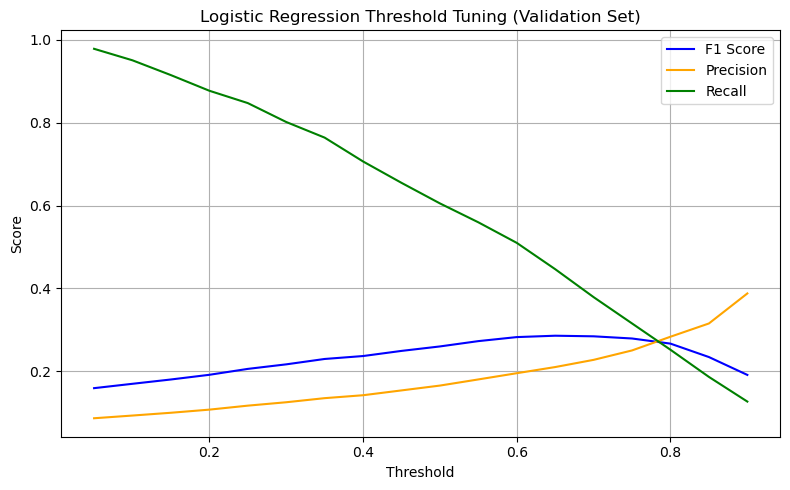


Logistic Regression (Final Test Performance @ Threshold = 0.65)
[[4766  881]
 [ 287  217]]
              precision    recall  f1-score   support

           0      0.943     0.844     0.891      5647
           1      0.198     0.431     0.271       504

    accuracy                          0.810      6151
   macro avg      0.570     0.637     0.581      6151
weighted avg      0.882     0.810     0.840      6151



In [43]:
# Train the model on training set
baseline_lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear',
    random_state=42
)

baseline_lr.fit(X_train_scaled, y_train)

# Predict probabilities on validation set
y_pred_proba_val = baseline_lr.predict_proba(X_val_scaled)[:, 1]

# Threshold tuning on validation set only
thresholds = np.arange(0.05, 0.95, 0.05)
f1s = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_thresh = (y_pred_proba_val > t).astype(int)
    precision = precision_score(y_val, y_pred_thresh)
    recall = recall_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f"Threshold: {t:.2f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

# Plot performance vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Logistic Regression Threshold Tuning (Validation Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate on test set using best threshold from validation set
optimal_threshold_lr = thresholds[np.argmax(f1s)]
y_pred_proba_lr = baseline_lr.predict_proba(X_test_scaled)[:, 1]
y_pred_label_lr = (y_pred_proba_lr > optimal_threshold_lr).astype(int)

print(f"\nLogistic Regression (Final Test Performance @ Threshold = {optimal_threshold_lr:.2f})")
print(confusion_matrix(y_test, y_pred_label_lr))
print(classification_report(y_test, y_pred_label_lr, digits=3))


## 4.2 Random Forest

- A Random Forest classifier is trained as a second baseline model, leveraging its ability to handle complex, non-linear feature interactions without requiring feature scaling.
- The initial model uses default hyperparameters with class balancing enabled to account for severe class imbalance in the target variable.
- Performance is evaluated using AUC, precision, recall, F1-score, and a confusion matrix, using a default threshold of 0.5.
- Optuna is then used to perform hyperparameter tuning with cross-validated AUC as the objective function.
- The best model from the Optuna search is retrained, and a threshold sweep is conducted to identify the optimal decision threshold for classification.
- Final evaluation is performed on the holdout test set using the tuned threshold.

### Initial model (default parameters)

In [44]:
# Initial Random Forest (no tuning) 
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_unscaled, y_train)

y_pred_proba_rf = rf_model.predict_proba(X_test_unscaled)[:, 1]
y_pred_rf_default = (y_pred_proba_rf > 0.5).astype(int)

print("Initial Random Forest (Threshold = 0.5)")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(classification_report(y_test, y_pred_rf_default, digits=3))
print(confusion_matrix(y_test, y_pred_rf_default))

Initial Random Forest (Threshold = 0.5)
AUC: 0.6976
              precision    recall  f1-score   support

           0      0.918     1.000     0.957      5647
           1      0.500     0.002     0.004       504

    accuracy                          0.918      6151
   macro avg      0.709     0.501     0.481      6151
weighted avg      0.884     0.918     0.879      6151

[[5646    1]
 [ 503    1]]


### Hyperparameter Tuning with Optuna

In [45]:
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    
    def objective(trial):
        params = {
            'n_estimators'     : trial.suggest_int ('n_estimators', 100, 1000),
            'max_depth'        : trial.suggest_int ('max_depth',      3,   20),
            'min_samples_split': trial.suggest_int ('min_samples_split', 2, 20),
            'min_samples_leaf' : trial.suggest_int ('min_samples_leaf',  1, 20),
            'max_features'     : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'class_weight'     : trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
            'random_state'     : 42,
            'n_jobs'           : -1,
        }

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_unscaled, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, preds)

    pruner = SuccessiveHalvingPruner()
    study  = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=50, n_jobs=-1)

print(f"Best AUC : {study.best_value:.4f}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

Best AUC : 0.7672
Best Parameters:
n_estimators: 779
max_depth: 16
min_samples_split: 18
min_samples_leaf: 19
max_features: None
class_weight: balanced_subsample


### Retrain and Threshold Tuning

Threshold Tuning Results
Threshold: 0.05 | Precision: 0.083 | Recall: 0.994 | F1: 0.154
Threshold: 0.10 | Precision: 0.094 | Recall: 0.964 | F1: 0.172
Threshold: 0.15 | Precision: 0.111 | Recall: 0.895 | F1: 0.197
Threshold: 0.20 | Precision: 0.132 | Recall: 0.813 | F1: 0.227
Threshold: 0.25 | Precision: 0.152 | Recall: 0.712 | F1: 0.251
Threshold: 0.30 | Precision: 0.175 | Recall: 0.603 | F1: 0.271
Threshold: 0.35 | Precision: 0.197 | Recall: 0.510 | F1: 0.284
Threshold: 0.40 | Precision: 0.222 | Recall: 0.427 | F1: 0.292
Threshold: 0.45 | Precision: 0.247 | Recall: 0.349 | F1: 0.289
Threshold: 0.50 | Precision: 0.269 | Recall: 0.276 | F1: 0.273
Threshold: 0.55 | Precision: 0.285 | Recall: 0.212 | F1: 0.243
Threshold: 0.60 | Precision: 0.308 | Recall: 0.145 | F1: 0.197
Threshold: 0.65 | Precision: 0.346 | Recall: 0.093 | F1: 0.147
Threshold: 0.70 | Precision: 0.342 | Recall: 0.054 | F1: 0.093
Threshold: 0.75 | Precision: 0.464 | Recall: 0.026 | F1: 0.049
Threshold: 0.80 | Precision: 0

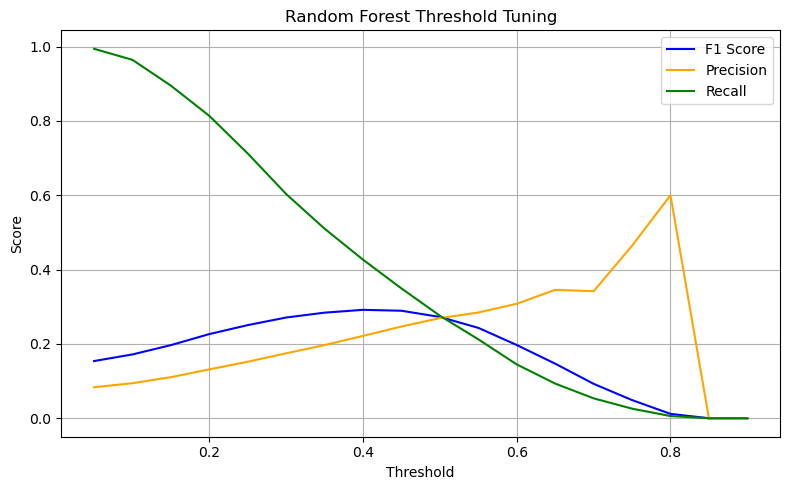


Final Evaluation (Threshold = 0.40)
AUC: 0.7401
              precision    recall  f1-score   support

           0      0.944     0.866     0.904      5647
           1      0.222     0.427     0.292       504

    accuracy                          0.830      6151
   macro avg      0.583     0.646     0.598      6151
weighted avg      0.885     0.830     0.853      6151

[[4892  755]
 [ 289  215]]


In [46]:
# Re-train with best params
best_params_rf = study.best_params
best_params_rf.update({'random_state': 42, 'n_jobs': -1})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train_unscaled, y_train)

y_pred_proba_rf = rf_model.predict_proba(X_test_unscaled)[:, 1]

# Threshold sweep
thresholds = np.arange(0.05, 0.95, 0.05)
precisions, recalls, f1s = [], [], []

print("Threshold Tuning Results")
for t in thresholds:
    y_pred_thresh = (y_pred_proba_rf > t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.3f} | Recall: {recalls[-1]:.3f} | F1: {f1s[-1]:.3f}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Random Forest Threshold Tuning")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation
best_idx = np.argmax(f1s)
best_threshold_rf = thresholds[best_idx]
y_pred_rf_final = (y_pred_proba_rf > best_threshold_rf).astype(int)

print(f"\nFinal Evaluation (Threshold = {best_threshold_rf:.2f})")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(classification_report(y_test, y_pred_rf_final, digits=3))
print(confusion_matrix(y_test, y_pred_rf_final))

## 4.3 XGBoost

- This section implements a full XGBoost classification pipeline using a scaled 60/20/20 train/val/test split.
    - We begin with an initial model using default hyperparameters and evaluate performance using AUC, precision, recall, and F1 score.
    - Next, we tune the model using Optuna with a validation split nested inside the training set. The tuning objective maximizes AUC.
    - After hyperparameter tuning, we retrain the model on the full training set using the best parameters.
    - We then sweep through decision thresholds from 0.05 to 0.95 to identify the threshold that maximizes F1 score, balancing precision and recall.
    - Final model performance is evaluated on the held-out test set using the optimal threshold.

### Initial model (default parameters)

In [ ]:
# Initialize and train
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)

# Predict probabilities and labels
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb_default = (y_pred_proba_xgb > 0.5).astype(int)

# Report
print("Initial XGBoost (Threshold = 0.5)")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb_default, digits=3))
print(confusion_matrix(y_test, y_pred_xgb_default))

Initial XGBoost (Threshold = 0.5)
AUC: 0.7615
              precision    recall  f1-score   support

           0      0.919     0.999     0.957      5647
           1      0.429     0.012     0.023       504

    accuracy                          0.918      6151
   macro avg      0.674     0.505     0.490      6151
weighted avg      0.879     0.918     0.881      6151

[[5639    8]
 [ 498    6]]


### Hyperparameter tuning with Optuna

In [48]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'n_jobs': -1,
        'random_state': 42
    }

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    model = XGBClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)

    preds = model.predict_proba(X_val)[:, 1]
    return float(roc_auc_score(y_val, preds))

# Run optimization
pruner = SuccessiveHalvingPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=50, n_jobs=-1)

print(f"Best AUC: {study.best_value:.4f}")
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

Best AUC: 0.7791
Best parameters:
n_estimators: 877
max_depth: 5
learning_rate: 0.06263537566244079
subsample: 0.8697660901175297
colsample_bytree: 0.8110399488499476
scale_pos_weight: 3.0941905483954972


### Retrain and threshold tuning

Threshold Sweep:
Threshold: 0.05 | Precision: 0.160 | Recall: 0.681 | F1: 0.259
Threshold: 0.10 | Precision: 0.202 | Recall: 0.508 | F1: 0.289
Threshold: 0.15 | Precision: 0.235 | Recall: 0.401 | F1: 0.297
Threshold: 0.20 | Precision: 0.257 | Recall: 0.313 | F1: 0.283
Threshold: 0.25 | Precision: 0.281 | Recall: 0.246 | F1: 0.262
Threshold: 0.30 | Precision: 0.304 | Recall: 0.198 | F1: 0.240
Threshold: 0.35 | Precision: 0.307 | Recall: 0.157 | F1: 0.208
Threshold: 0.40 | Precision: 0.332 | Recall: 0.131 | F1: 0.188
Threshold: 0.45 | Precision: 0.371 | Recall: 0.111 | F1: 0.171
Threshold: 0.50 | Precision: 0.393 | Recall: 0.095 | F1: 0.153
Threshold: 0.55 | Precision: 0.421 | Recall: 0.079 | F1: 0.134
Threshold: 0.60 | Precision: 0.389 | Recall: 0.056 | F1: 0.097
Threshold: 0.65 | Precision: 0.423 | Recall: 0.044 | F1: 0.079
Threshold: 0.70 | Precision: 0.486 | Recall: 0.034 | F1: 0.063
Threshold: 0.75 | Precision: 0.520 | Recall: 0.026 | F1: 0.049
Threshold: 0.80 | Precision: 0.545 | R

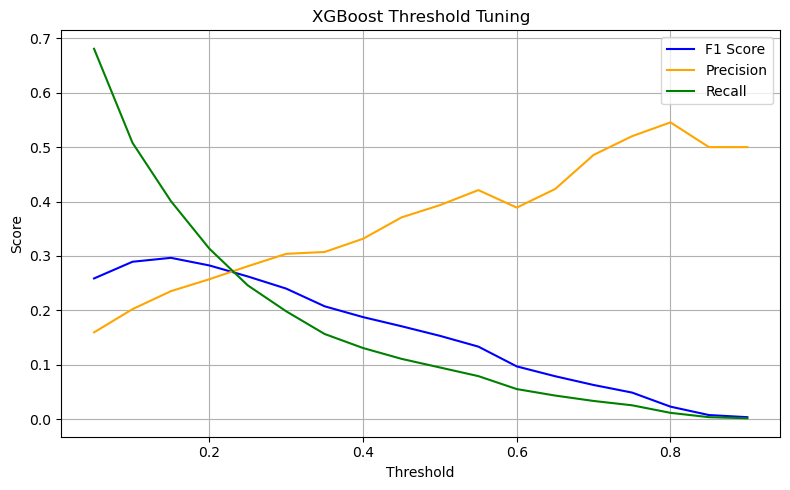


Best Threshold = 0.15 with F1 = 0.297


In [49]:
# Refit best model
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 42
})

xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train_scaled, y_train)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]


# Threshold tuning
thresholds = np.arange(0.05, 0.95, 0.05)
precisions, recalls, f1s = [], [], []

print("Threshold Sweep:")
for t in thresholds:
    y_pred_thresh = (y_pred_proba_xgb > t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.3f} | Recall: {recalls[-1]:.3f} | F1: {f1s[-1]:.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("XGBoost Threshold Tuning")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold
best_idx = np.argmax(f1s)
best_threshold_xgb = thresholds[best_idx]
print(f"\nBest Threshold = {best_threshold_xgb:.2f} with F1 = {f1s[best_idx]:.3f}")
y_pred_xgb_final = (y_pred_proba_xgb > best_threshold_xgb).astype(int)


## 4.4 CatBoost

- In this section, we train and evaluate a CatBoostClassifier, a gradient boosting model that natively handles categorical variables and does not require feature scaling.
- We use the unscaled input features (X_train_unscaled, X_test_unscaled) because CatBoost handles raw numerical ranges internally and is often robust to feature distributions.
- A baseline model is trained first with default hyperparameters.
- We then use Optuna with a SuccessiveHalvingPruner to tune critical parameters (e.g., depth, learning_rate, l2_leaf_reg, and class weights) to maximize AUC on a validation set.
- The best parameters are manually re-used in a retraining step.
- A threshold sweep is conducted to identify the optimal cutoff probability for classification, targeting the best F1 score.
- Finally, we evaluate the model using the optimal threshold and report AUC, precision, recall, and the full classification report.

### Initial run 

In [51]:
# Train baseline CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)

cat_model.fit(X_train_unscaled, y_train, eval_set=(X_val_unscaled, y_val), use_best_model=True, verbose=False)

# Predict probabilities on test set 
y_pred_proba_cat = cat_model.predict_proba(X_test_unscaled)[:, 1]
y_pred_cat_default = (y_pred_proba_cat > 0.5).astype(int)

# Initial report at threshold 0.5
print("Initial Run (Threshold = 0.5)")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")
print(classification_report(y_test, y_pred_cat_default, digits=3))
print(confusion_matrix(y_test, y_pred_cat_default))

Initial Run (Threshold = 0.5)
AUC: 0.7552
              precision    recall  f1-score   support

           0      0.919     0.999     0.957      5647
           1      0.545     0.012     0.023       504

    accuracy                          0.918      6151
   macro avg      0.732     0.506     0.490      6151
weighted avg      0.888     0.918     0.881      6151

[[5642    5]
 [ 498    6]]


### Optuna Tuning 

In [53]:
def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bootstrap_type': 'Bernoulli',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'early_stopping_rounds': 50,
        'verbose': False,
        'class_weights': [1, 15],  
    }

    X_tr, X_val_fold, y_tr, y_val_fold = train_test_split(
        X_train_unscaled, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    model = CatBoostClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=(X_val_fold, y_val_fold), use_best_model=True)
    preds = model.predict_proba(X_val_fold)[:, 1]
    return roc_auc_score(y_val_fold, preds)

pruner = SuccessiveHalvingPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=50, n_jobs=-1)

print(f"Best AUC: {study.best_value}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


Best AUC: 0.7769934009398187
Best Parameters:
learning_rate: 0.017401062497184344
depth: 4
l2_leaf_reg: 6.11798718499005


### Retrain on full train/val with best params

In [ ]:
# Combine full training data for retraining
X_trainval = X_train_unscaled
y_trainval = y_train

# Extract best params from Optuna study
best_params_cat = study.best_params

# Add fixed parameters that aren't tuned
best_params_cat.update({
    'iterations': 1000,
    'bootstrap_type': 'Bernoulli',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': False,
    'class_weights': [1, 15]  # : tune if needed
})

# Retrain CatBoostClassifier with full train set and best hyperparameters
cat_model = CatBoostClassifier(**best_params_cat)

cat_model.fit(
    X_trainval,
    y_trainval,
    eval_set=(X_test_unscaled, y_test),
    use_best_model=True
)

# Predict on test set
y_pred_proba_cat = cat_model.predict_proba(X_test_unscaled)[:, 1]

0:	test: 0.6639175	best: 0.6639175 (0)	total: 27.9ms	remaining: 27.8s
100:	test: 0.7372920	best: 0.7374698 (99)	total: 2.61s	remaining: 23.2s
200:	test: 0.7474091	best: 0.7475647 (198)	total: 5.35s	remaining: 21.3s
300:	test: 0.7544342	best: 0.7544781 (299)	total: 7.95s	remaining: 18.5s
400:	test: 0.7580268	best: 0.7580792 (397)	total: 10.6s	remaining: 15.8s
500:	test: 0.7595591	best: 0.7595591 (500)	total: 13.2s	remaining: 13.1s
600:	test: 0.7621577	best: 0.7623123 (595)	total: 15.7s	remaining: 10.4s
700:	test: 0.7640273	best: 0.7641004 (699)	total: 18.3s	remaining: 7.81s
800:	test: 0.7652799	best: 0.7653361 (784)	total: 21s	remaining: 5.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7660887506
bestIteration = 844

Shrink model to first 845 iterations.


### Threshold tuning

Threshold Tuning Results
Threshold: 0.05 | Precision: 0.082 | Recall: 1.000 | F1: 0.151
Threshold: 0.10 | Precision: 0.083 | Recall: 0.996 | F1: 0.153
Threshold: 0.15 | Precision: 0.086 | Recall: 0.994 | F1: 0.158
Threshold: 0.20 | Precision: 0.090 | Recall: 0.984 | F1: 0.166
Threshold: 0.25 | Precision: 0.097 | Recall: 0.970 | F1: 0.176
Threshold: 0.30 | Precision: 0.106 | Recall: 0.946 | F1: 0.190
Threshold: 0.35 | Precision: 0.115 | Recall: 0.913 | F1: 0.205
Threshold: 0.40 | Precision: 0.127 | Recall: 0.877 | F1: 0.221
Threshold: 0.45 | Precision: 0.138 | Recall: 0.819 | F1: 0.237
Threshold: 0.50 | Precision: 0.154 | Recall: 0.760 | F1: 0.256
Threshold: 0.55 | Precision: 0.178 | Recall: 0.704 | F1: 0.284
Threshold: 0.60 | Precision: 0.203 | Recall: 0.619 | F1: 0.305
Threshold: 0.65 | Precision: 0.223 | Recall: 0.516 | F1: 0.311
Threshold: 0.70 | Precision: 0.248 | Recall: 0.393 | F1: 0.304
Threshold: 0.75 | Precision: 0.275 | Recall: 0.284 | F1: 0.279
Threshold: 0.80 | Precision: 0

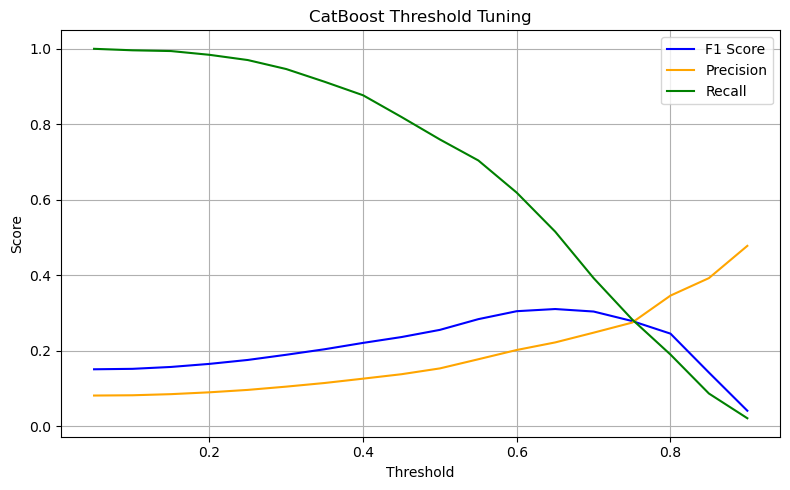


Best Threshold = 0.65 with F1 = 0.311


In [55]:
# Sweep thresholds
thresholds = np.arange(0.05, 0.95, 0.05)
precisions, recalls, f1s = [], [], []

print("Threshold Tuning Results")
for t in thresholds:
    y_pred_thresh = (y_pred_proba_cat > t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.3f} | Recall: {recalls[-1]:.3f} | F1: {f1s[-1]:.3f}")

# Plot threshold sweep
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s, label='F1 Score', color='blue')
plt.plot(thresholds, precisions, label='Precision', color='orange')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.title("CatBoost Threshold Tuning")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find best threshold
best_idx = np.argmax(f1s)
best_threshold_cat = thresholds[best_idx]
print(f"\nBest Threshold = {best_threshold_cat:.2f} with F1 = {f1s[best_idx]:.3f}")

### Final evaluation 

In [56]:
# Final predictions
y_pred_cat_final = (y_pred_proba_cat > best_threshold_cat).astype(int)

print(f"Final Evaluation (Threshold = {best_threshold_cat:.2f})")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")
print(classification_report(y_test, y_pred_cat_final, digits=3))
print(confusion_matrix(y_test, y_pred_cat_final))

Final Evaluation (Threshold = 0.65)
AUC: 0.7661
              precision    recall  f1-score   support

           0      0.951     0.839     0.892      5647
           1      0.223     0.516     0.311       504

    accuracy                          0.813      6151
   macro avg      0.587     0.678     0.601      6151
weighted avg      0.891     0.813     0.844      6151

[[4739  908]
 [ 244  260]]


## 4.5 LightGBM 

- In this section, we implement and evaluate a LightGBM (LGBM) classifier for binary classification. 
- LightGBM is a gradient boosting framework known for its speed and efficiency, particularly with large datasets and sparse features. 
- Since LightGBM does not handle special characters in feature names, we first sanitize column headers to ensure compatibility.
- We begin by training a baseline LightGBM model using the scaled training set. 
- Probabilistic outputs are used to calculate ROC-AUC and generate default threshold classification metrics. 
- Next, we perform hyperparameter tuning using Optuna to maximize AUC on a validation subset of the training data. 
- The best parameters are then used to retrain the model on the full training set.
- To further optimize performance, we sweep through a range of classification thresholds (0.05 to 0.95) and evaluate precision, recall, and F1 scores at each point. 

### Initial run 

Threshold: 0.05 | Precision: 0.115 | Recall: 0.851 | F1: 0.203
Threshold: 0.10 | Precision: 0.139 | Recall: 0.740 | F1: 0.234
Threshold: 0.15 | Precision: 0.153 | Recall: 0.619 | F1: 0.246
Threshold: 0.20 | Precision: 0.176 | Recall: 0.562 | F1: 0.268
Threshold: 0.25 | Precision: 0.189 | Recall: 0.482 | F1: 0.271
Threshold: 0.30 | Precision: 0.203 | Recall: 0.419 | F1: 0.273
Threshold: 0.35 | Precision: 0.220 | Recall: 0.361 | F1: 0.274
Threshold: 0.40 | Precision: 0.240 | Recall: 0.313 | F1: 0.272
Threshold: 0.45 | Precision: 0.258 | Recall: 0.268 | F1: 0.263
Threshold: 0.50 | Precision: 0.271 | Recall: 0.214 | F1: 0.239
Threshold: 0.55 | Precision: 0.307 | Recall: 0.192 | F1: 0.237
Threshold: 0.60 | Precision: 0.340 | Recall: 0.163 | F1: 0.220
Threshold: 0.65 | Precision: 0.371 | Recall: 0.137 | F1: 0.200
Threshold: 0.70 | Precision: 0.388 | Recall: 0.099 | F1: 0.158
Threshold: 0.75 | Precision: 0.396 | Recall: 0.071 | F1: 0.121
Threshold: 0.80 | Precision: 0.456 | Recall: 0.052 | F1

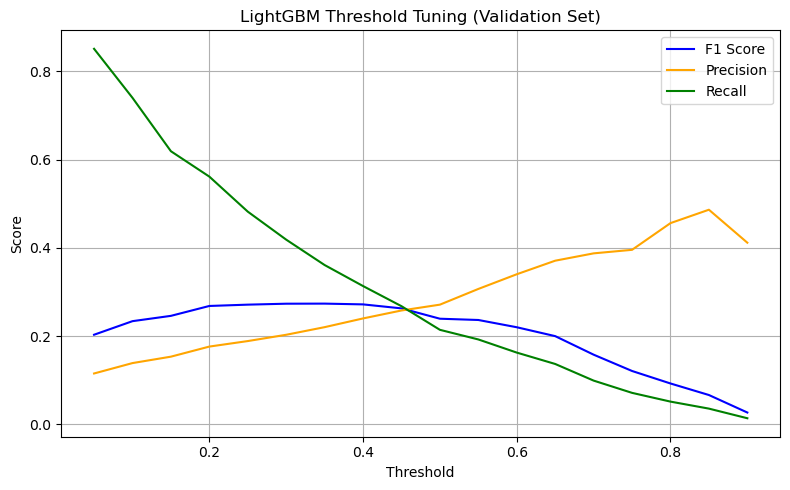


Best Threshold = 0.35 with F1 = 0.274

Final Evaluation (Test Set) – Threshold = 0.35
AUC: 0.7296
              precision    recall  f1-score   support

           0      0.940     0.884     0.911      5647
           1      0.221     0.369     0.276       504

    accuracy                          0.841      6151
   macro avg      0.580     0.626     0.594      6151
weighted avg      0.881     0.841     0.859      6151

[[4990  657]
 [ 318  186]]


In [58]:

# Clean column name
X_train_scaled.columns = X_train_scaled.columns.str.replace(r"[^\w]", "_", regex=True)
X_val_scaled.columns   = X_val_scaled.columns.str.replace(r"[^\w]", "_", regex=True)
X_test_scaled.columns  = X_test_scaled.columns.str.replace(r"[^\w]", "_", regex=True)


# Initialise LightGBM
from lightgbm import LGBMClassifier
import contextlib, io
                    # global silence, one‑time
lgbm_model = LGBMClassifier(
    n_estimators     = 1000,
    learning_rate    = 0.05,
    max_depth        = 5,
    class_weight     = 'balanced',
    subsample        = 0.8,
    colsample_bytree = 0.8,
    random_state     = 42,
    n_jobs           = 1,
    verbosity        = -1                        # local safety net
)


# Train model 
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    lgbm_model.fit(X_train_scaled, y_train)

# Predict probabilities on validation set 
y_pred_proba_val_lgbm = lgbm_model.predict_proba(X_val_scaled)[:, 1]

thresholds  = np.arange(0.05, 0.95, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = (y_pred_proba_val_lgbm > t).astype(int)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))
    f1s.append(f1_score(y_val, preds))
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.3f} | "
          f"Recall: {recalls[-1]:.3f} | F1: {f1s[-1]:.3f}")

# Plot threshold metrics 
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s,         label='F1 Score',  color='blue')
plt.plot(thresholds, precisions,  label='Precision', color='orange')
plt.plot(thresholds, recalls,     label='Recall',    color='green')
plt.title("LightGBM Threshold Tuning (Validation Set)")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Select best threshold from validation F1
best_idx          = np.argmax(f1s)
best_threshold    = thresholds[best_idx]
print(f"\nBest Threshold = {best_threshold:.2f} with F1 = {f1s[best_idx]:.3f}")

# Predict on test set with best threshold
y_pred_proba_test_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lgbm_final      = (y_pred_proba_test_lgbm > best_threshold).astype(int)

# Final test set evaluation
print(f"\nFinal Evaluation (Test Set) – Threshold = {best_threshold:.2f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_test_lgbm):.4f}")
print(classification_report(y_test, y_pred_lgbm_final, digits=3))
print(confusion_matrix(y_test, y_pred_lgbm_final))


### Optuna Tuning 

In [60]:
def objective(trial):
    params = {
        "n_estimators"     : trial.suggest_int   ("n_estimators",     100, 1000),
        "learning_rate"    : trial.suggest_float("learning_rate",    0.01, 0.3, log=True),
        "max_depth"        : trial.suggest_int   ("max_depth",          3, 12),
        "num_leaves"       : trial.suggest_int   ("num_leaves",         7, 256),
        "subsample"        : trial.suggest_float("subsample",        0.5, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "class_weight"     : "balanced",
        "random_state"     : 42,
        "n_jobs"           : -1,
        "boosting_type"    : "gbdt",
        "objective"        : "binary",
        "metric"           : "auc",
        "verbosity"        : -1,                    
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_scaled, y_train) 
    preds = model.predict_proba(X_val_scaled)[:, 1]
    return roc_auc_score(y_val, preds)

pruner = SuccessiveHalvingPruner()
study  = optuna.create_study(direction="maximize", pruner=pruner)

# 3 ─ run optimisation with stdout/stderr captured
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    study.optimize(objective, n_trials=50, n_jobs=-1)

# 4 ─ only the wanted summary is printed
print(f"Best AUC: {study.best_value}")
print("Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


Best AUC: 0.7512208390263649
Best Parameters:
n_estimators: 454
learning_rate: 0.01735647221222029
max_depth: 12
num_leaves: 17
subsample: 0.6216329271252681
colsample_bytree: 0.7773413401574687


### Threshold tuning

Threshold Tuning (Validation Set)
Threshold: 0.05 | Precision: 0.131 | Recall: 0.827 | F1: 0.226
Threshold: 0.10 | Precision: 0.190 | Recall: 0.552 | F1: 0.283
Threshold: 0.15 | Precision: 0.244 | Recall: 0.401 | F1: 0.303
Threshold: 0.20 | Precision: 0.321 | Recall: 0.312 | F1: 0.316
Threshold: 0.25 | Precision: 0.348 | Recall: 0.218 | F1: 0.268
Threshold: 0.30 | Precision: 0.385 | Recall: 0.137 | F1: 0.202
Threshold: 0.35 | Precision: 0.490 | Recall: 0.099 | F1: 0.165
Threshold: 0.40 | Precision: 0.576 | Recall: 0.067 | F1: 0.121
Threshold: 0.45 | Precision: 0.632 | Recall: 0.048 | F1: 0.089
Threshold: 0.50 | Precision: 0.750 | Recall: 0.036 | F1: 0.068
Threshold: 0.55 | Precision: 0.727 | Recall: 0.016 | F1: 0.031
Threshold: 0.60 | Precision: 0.800 | Recall: 0.008 | F1: 0.016
Threshold: 0.65 | Precision: 0.000 | Recall: 0.000 | F1: 0.000
Threshold: 0.70 | Precision: 0.000 | Recall: 0.000 | F1: 0.000
Threshold: 0.75 | Precision: 0.000 | Recall: 0.000 | F1: 0.000
Threshold: 0.80 | Pre

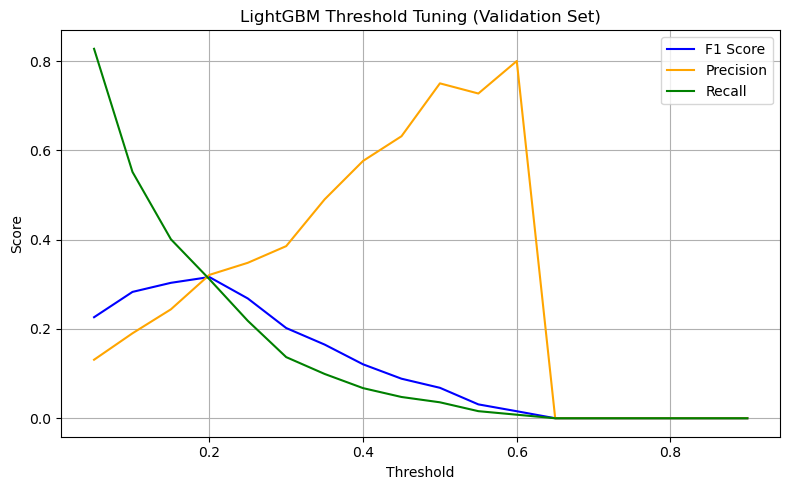


Best Threshold = 0.20 with F1 = 0.316


In [62]:
# retrain model quietly
best_params_lgbm = study.best_params
lgbm_model = LGBMClassifier(**best_params_lgbm, verbosity=-1)

with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    lgbm_model.fit(X_train_scaled, y_train)

# threshold sweep (prints & plot REMAIN)
y_pred_proba_val = lgbm_model.predict_proba(X_val_scaled)[:, 1]

thresholds          = np.arange(0.05, 0.95, 0.05)
precisions, recalls = [], []
f1s                 = []

print("Threshold Tuning (Validation Set)")
for t in thresholds:
    preds = (y_pred_proba_val > t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score  (y_val, preds))
    f1s.append     (f1_score     (y_val, preds))
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.3f} | "
          f"Recall: {recalls[-1]:.3f} | F1: {f1s[-1]:.3f}")

# plot tuning curves
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1s,        label="F1 Score",  color="blue")
plt.plot(thresholds, precisions, label="Precision", color="orange")
plt.plot(thresholds, recalls,    label="Recall",    color="green")
plt.title("LightGBM Threshold Tuning (Validation Set)")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# pick best threshold & report
best_idx         = np.argmax(f1s)
best_threshold   = thresholds[best_idx]
print(f"\nBest Threshold = {best_threshold:.2f} with F1 = {f1s[best_idx]:.3f}")


### Final evaluation 

In [66]:
#  Predict on test set using best threshold 
y_pred_proba_test_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lgbm_final = (y_pred_proba_test_lgbm > best_threshold).astype(int)

#  Report final results 
print(f"\nFinal Evaluation (Test Set) — Threshold = {best_threshold:.2f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_test_lgbm):.4f}")
print(classification_report(y_test, y_pred_lgbm_final, digits=3))
print(confusion_matrix(y_test, y_pred_lgbm_final))


Final Evaluation (Test Set) — Threshold = 0.20
AUC: 0.7632
              precision    recall  f1-score   support

           0      0.938     0.936     0.937      5647
           1      0.295     0.302     0.298       504

    accuracy                          0.884      6151
   macro avg      0.616     0.619     0.617      6151
weighted avg      0.885     0.884     0.884      6151

[[5284  363]
 [ 352  152]]


# Section 5: Model selection
***

## 5.1 Summary metrics 

Final Model Comparison


,AUC,Precision,Recall,F1 Score
Model,,,,
CatBoost,0.766,0.223,0.516,0.311
LightGBM,0.763,0.295,0.302,0.298
XGBoost,0.747,0.235,0.401,0.297
Random Forest,0.740,0.222,0.427,0.292
Logistic Regression,0.722,0.198,0.431,0.271


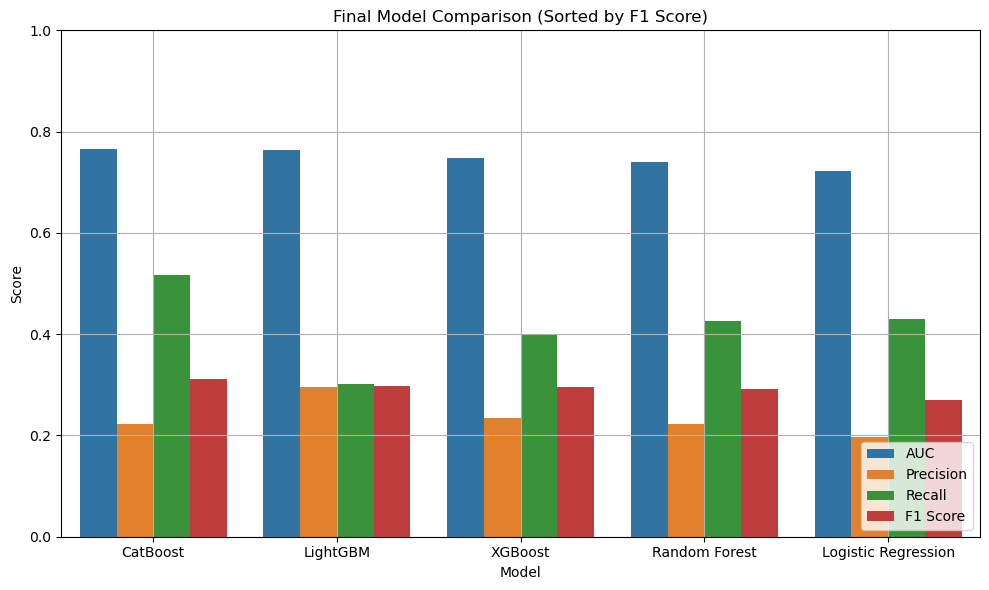

In [67]:
# Dictionary of final predictions (proba + label)
final_preds = {
    "Logistic Regression": (y_pred_proba_lr, y_pred_label_lr),
    "Random Forest": (y_pred_proba_rf, y_pred_rf_final),
    "XGBoost": (y_pred_proba_xgb, y_pred_xgb_final),
    "CatBoost": (y_pred_proba_cat, y_pred_cat_final),
    "LightGBM": (y_pred_proba_test_lgbm, y_pred_lgbm_final),
}

# Collect metrics
comparison = []
for model_name, (proba, labels) in final_preds.items():
    comparison.append({
        "Model": model_name,
        "AUC": roc_auc_score(y_test, proba),
        "Precision": precision_score(y_test, labels),
        "Recall": recall_score(y_test, labels),
        "F1 Score": f1_score(y_test, labels),
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison).sort_values(by="F1 Score", ascending=False)

# Display table
print("Final Model Comparison")
display(comparison_df.set_index("Model").style.format("{:.3f}"))

# Plot metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
            x="Model", y="Score", hue="Metric")
plt.title("Final Model Comparison (Sorted by F1 Score)")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Section 6: Feature engineering 
***

## 6.1 Feature analysis

### SHAP function


Generating SHAP explanations for: CatBoost

CatBoost - Global Feature Importance


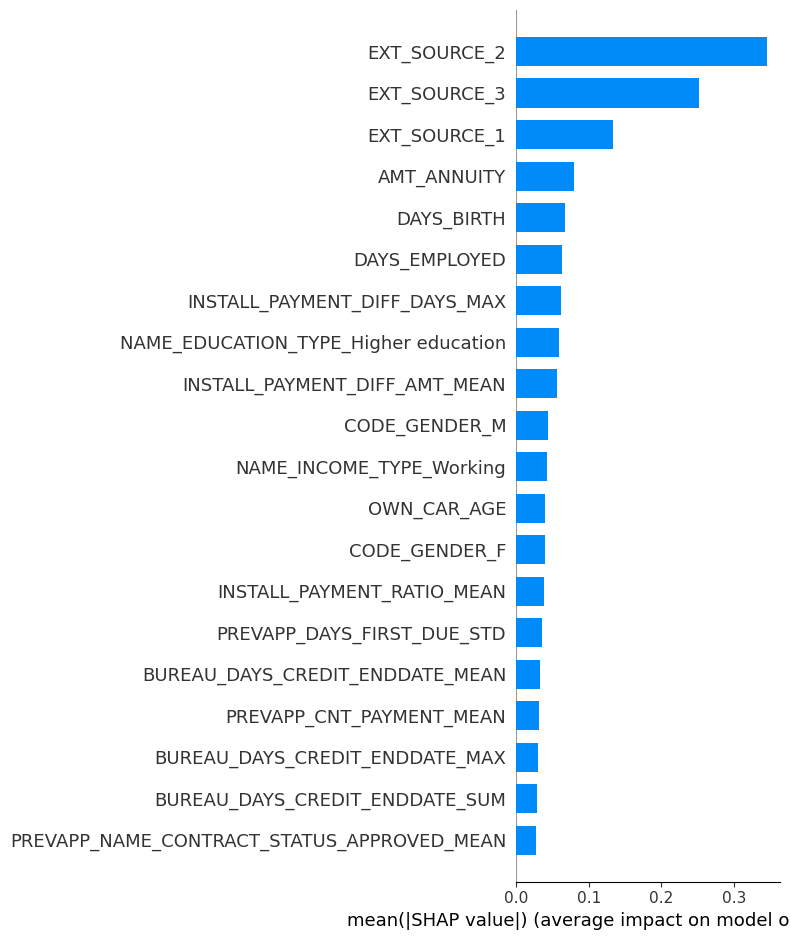


CatBoost - SHAP Summary Plot


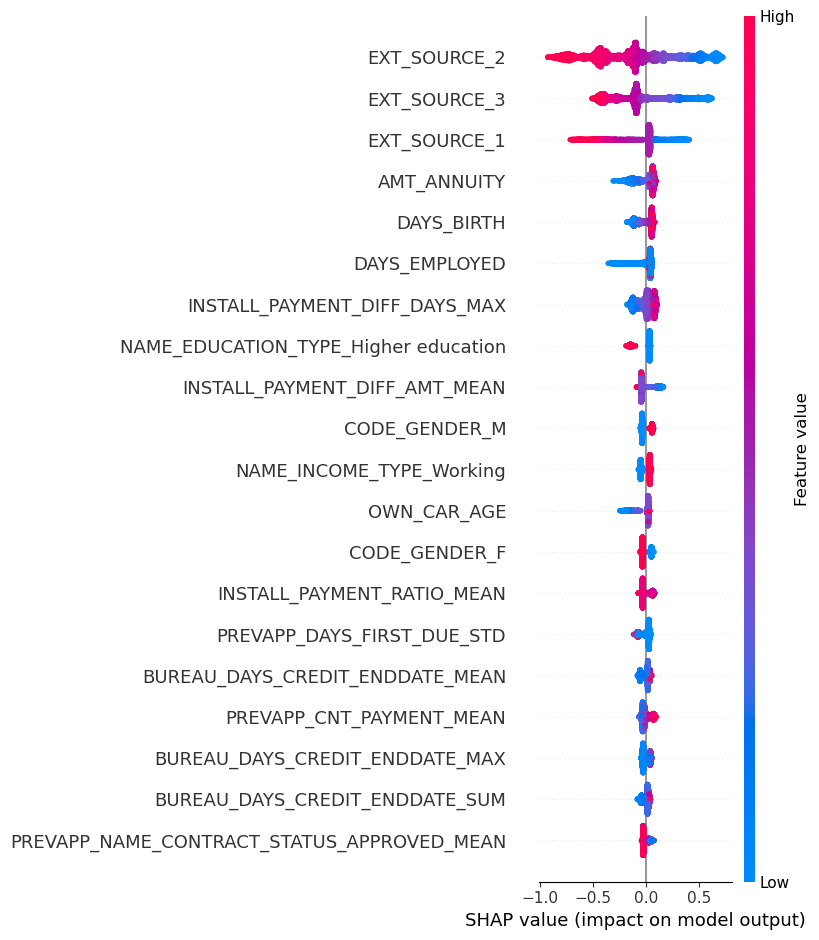


CatBoost - SHAP Force Plot for Row 433 (Prob = 0.952)


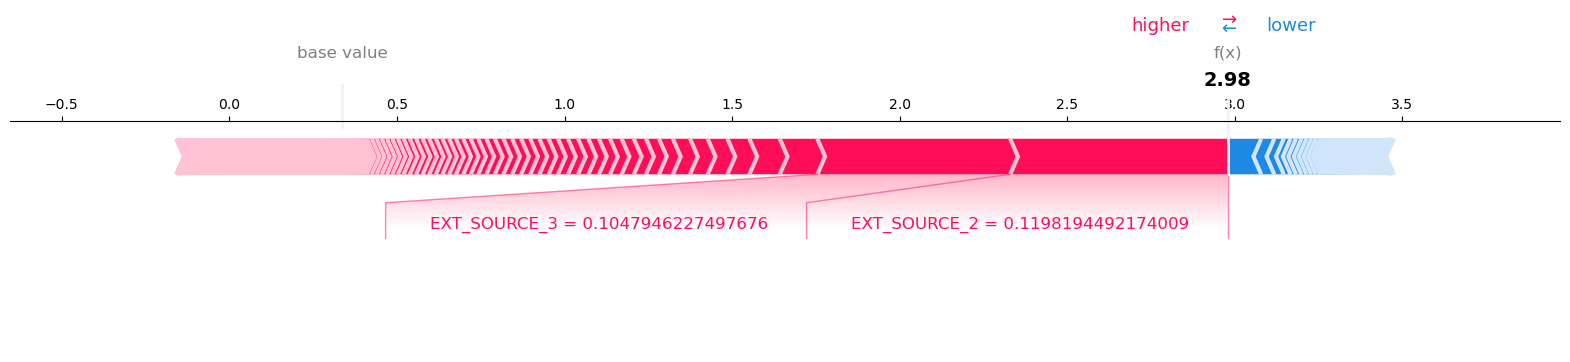


CatBoost - SHAP Force Plot for Row 4759 (Prob = 0.933)


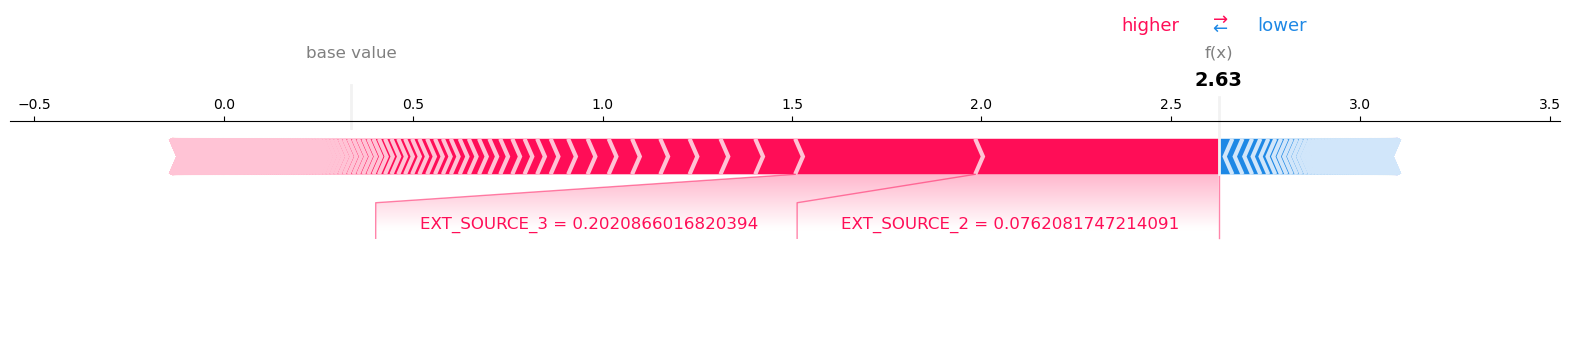


CatBoost - SHAP Force Plot for Row 5004 (Prob = 0.931)


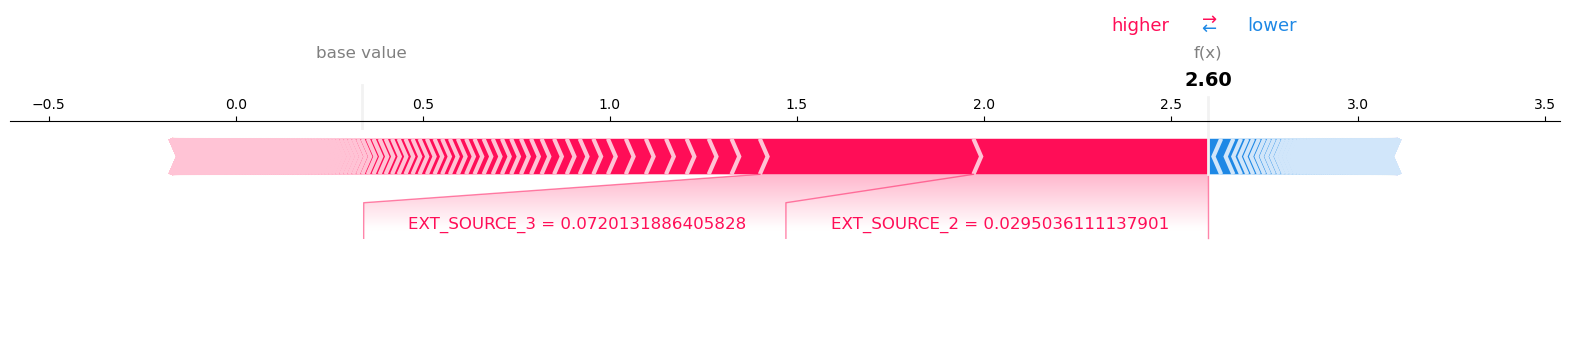

In [68]:
def explain_model_with_shap(model, X, model_name="Model", pred_probs=None, class_index=None, top_n=3):
    """
    Generate SHAP summary and force plots for a tree-based model.
    
    Parameters:
    - model: trained model (XGBoost, LightGBM, CatBoost, Random Forest)
    - X: DataFrame of features
    - model_name: Title used in plots
    - pred_probs:  predicted probabilities (for top_n force plots)
    - class_index: needed if shap_values returns a list (e.g., RF, CatBoost)
    - top_n: Number of highest-risk examples to show in force plots
    """
    
    print(f"\nGenerating SHAP explanations for: {model_name}")
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Handle binary classification models that return list of arrays
    if isinstance(shap_values, list):
        if class_index is None:
            class_index = 1  # default to positive class
        shap_values = shap_values[class_index]
        expected_value = explainer.expected_value[class_index]
    else:
        expected_value = explainer.expected_value

    # Global feature importance (bar plot)
    print(f"\n{model_name} - Global Feature Importance")
    shap.summary_plot(shap_values, X, plot_type="bar")

    # SHAP summary (violin plot)
    print(f"\n{model_name} - SHAP Summary Plot")
    shap.summary_plot(shap_values, X)

    # local force plots for top_n predicted positives
    if pred_probs is not None:
        top_idx = np.argsort(pred_probs)[-top_n:]
        for i in reversed(top_idx):
            print(f"\n{model_name} - SHAP Force Plot for Row {i} (Prob = {pred_probs[i]:.3f})")
            shap.force_plot(
                base_value=expected_value,
                shap_values=shap_values[i],
                features=X.iloc[i],
                matplotlib=True
            )
            
# SHAP interpretation for CatBoost (final tuned model)
explain_model_with_shap(
    model=cat_model,                        # final CatBoost model
    X=X_test_unscaled,                      # CatBoost prefers unscaled features
    model_name="CatBoost",                 
    pred_probs=y_pred_proba_cat,           # raw predicted probabilities
    class_index=1                           # since CatBoost returns list of SHAP arrays
)

### Feature engineering (CatBoost)

In [69]:
# Start with working copies of unscaled sets 
X_train_catboost = X_train_unscaled.copy()
X_test_catboost = X_test_unscaled.copy()

# Combine for uniform feature engineering 
X_catboost_full = pd.concat([X_train_catboost, X_test_catboost])
X_catboost_full.sort_index(inplace=True)  # preserve alignment

# Ratio-based feature interactions 
X_catboost_full['CREDIT_INCOME_RATIO'] = X_catboost_full['AMT_CREDIT'] / (X_catboost_full['AMT_INCOME_TOTAL'] + 1e-5)
X_catboost_full['ANNUITY_INCOME_RATIO'] = X_catboost_full['AMT_ANNUITY'] / (X_catboost_full['AMT_INCOME_TOTAL'] + 1e-5)
X_catboost_full['GOODS_CREDIT_RATIO'] = X_catboost_full['AMT_GOODS_PRICE'] / (X_catboost_full['AMT_CREDIT'] + 1e-5)
X_catboost_full['EMPLOYED_BIRTH_RATIO'] = X_catboost_full['DAYS_EMPLOYED'] / (X_catboost_full['DAYS_BIRTH'] + 1e-5)

# Log transforms 
X_catboost_full['LOG_CREDIT'] = np.log1p(X_catboost_full['AMT_CREDIT'])
X_catboost_full['LOG_INCOME'] = np.log1p(X_catboost_full['AMT_INCOME_TOTAL'])
X_catboost_full['LOG_EMPLOYED_RATIO'] = np.log1p(abs(X_catboost_full['EMPLOYED_BIRTH_RATIO']))

# Temporal ratios 
X_catboost_full['REGISTRATION_AGE_RATIO'] = X_catboost_full['DAYS_REGISTRATION'] / (X_catboost_full['DAYS_BIRTH'] + 1e-5)
X_catboost_full['ID_PUBLISH_AGE_RATIO'] = X_catboost_full['DAYS_ID_PUBLISH'] / (X_catboost_full['DAYS_BIRTH'] + 1e-5)

# Document and contact flags 
doc_flags = [col for col in X_catboost_full.columns if 'FLAG_DOCUMENT' in col]
X_catboost_full['NUM_DOCUMENTS_SUBMITTED'] = X_catboost_full[doc_flags].sum(axis=1)

contact_flags = ['FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']
X_catboost_full['NUM_CONTACT_FLAGS'] = X_catboost_full[contact_flags].sum(axis=1)

# Social circle default ratios 
X_catboost_full['DEF_30_RATIO'] = X_catboost_full['DEF_30_CNT_SOCIAL_CIRCLE'] / (X_catboost_full['OBS_30_CNT_SOCIAL_CIRCLE'] + 1e-5)
X_catboost_full['DEF_60_RATIO'] = X_catboost_full['DEF_60_CNT_SOCIAL_CIRCLE'] / (X_catboost_full['OBS_60_CNT_SOCIAL_CIRCLE'] + 1e-5)

print(f"Feature engineering complete. New shape: {X_catboost_full.shape}")

# Restore original train/test split 
X_train_catboost = X_catboost_full.loc[X_train_unscaled.index]
X_test_catboost = X_catboost_full.loc[X_test_unscaled.index]
y_train_catboost = y_train.copy()
y_test_catboost = y_test.copy()

# Confirm shapes and class balance 
print(f"X_train_catboost shape: {X_train_catboost.shape}")
print(f"X_test_catboost shape: {X_test_catboost.shape}")
print(f"\ny_train_catboost class balance:\n{y_train.value_counts(normalize=True)}")
print(f"\ny_test_catboost class balance:\n{y_test.value_counts(normalize=True)}")


Feature engineering complete. New shape: (24601, 727)
X_train_catboost shape: (18450, 727)
X_test_catboost shape: (6151, 727)

y_train_catboost class balance:
TARGET
0    0.918103
1    0.081897
Name: proportion, dtype: float64

y_test_catboost class balance:
TARGET
0    0.918062
1    0.081938
Name: proportion, dtype: float64


### Initial run (CatBoost with added features)

In [70]:
# Initialize CatBoost with default params
baseline_cb = CatBoostClassifier(
    verbose=0,
    random_state=42
)

# Train on engineered training set
baseline_cb.fit(X_train_catboost, y_train_catboost)

# Predict probabilities
y_pred_cb_proba = baseline_cb.predict_proba(X_test_catboost)[:, 1]

# Evaluate AUC
baseline_auc = roc_auc_score(y_test_catboost, y_pred_cb_proba)
print(f"📊 Initial CatBoost AUC: {baseline_auc:.4f}")

📊 Initial CatBoost AUC: 0.7666


### Oputna (CatBoost with added features)

In [72]:
def objective(trial):
    params = {
        "iterations"     : 1000,
        "learning_rate"  : trial.suggest_float ("learning_rate", 0.01, 0.3, log=True),
        "depth"          : trial.suggest_int   ("depth",          4,   10),
        "l2_leaf_reg"    : trial.suggest_float ("l2_leaf_reg",    1.0, 10.0),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "random_seed"    : 42,
        "eval_metric"    : "AUC",
        "verbose"        : False,               
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    skf  = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for tr_idx, val_idx in skf.split(X_train_catboost, y_train_catboost):
        X_tr, X_val = X_train_catboost.iloc[tr_idx], X_train_catboost.iloc[val_idx]
        y_tr, y_val = y_train_catboost.iloc[tr_idx], y_train_catboost.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50)
        preds = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, preds))

    return sum(aucs) / len(aucs)

# run Optuna with stdout/stderr captured
pruner = SuccessiveHalvingPruner()
study  = optuna.create_study(direction="maximize", pruner=pruner)

with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    study.optimize(objective, n_trials=30)

# final summary
print(f"Best CatBoost hyperparameters: {study.best_params}")


Best CatBoost hyperparameters: {'learning_rate': 0.018107443628869686, 'depth': 5, 'l2_leaf_reg': 6.541082945946988, 'bootstrap_type': 'MVS'}


### Threshold tuning (CatBoost with added features)

In [74]:
# Train best CatBoost model
best_cb = CatBoostClassifier(**study.best_params, iterations=1000, random_state=42, verbose=0)
best_cb.fit(X_train_catboost, y_train_catboost)

# Predict
y_pred_proba_cb = best_cb.predict_proba(X_test_catboost)[:, 1]

# Sweep thresholds
thresholds = np.arange(0.05, 0.95, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = (y_pred_proba_cb > t).astype(int)
    precisions.append(precision_score(y_test_catboost, preds))
    recalls.append(recall_score(y_test_catboost, preds))
    f1s.append(f1_score(y_test_catboost, preds))
    print(f"Threshold: {t:.2f} | Precision: {precisions[-1]:.3f} | Recall: {recalls[-1]:.3f} | F1: {f1s[-1]:.3f}")

# Get best threshold
best_idx = np.argmax(f1s)
best_threshold_cb = thresholds[best_idx]
print(f"\nBest Threshold = {best_threshold_cb:.2f} with F1 = {f1s[best_idx]:.3f}")

Threshold: 0.05 | Precision: 0.130 | Recall: 0.857 | F1: 0.226
Threshold: 0.10 | Precision: 0.200 | Recall: 0.603 | F1: 0.301
Threshold: 0.15 | Precision: 0.250 | Recall: 0.397 | F1: 0.307
Threshold: 0.20 | Precision: 0.283 | Recall: 0.270 | F1: 0.276
Threshold: 0.25 | Precision: 0.340 | Recall: 0.204 | F1: 0.255
Threshold: 0.30 | Precision: 0.418 | Recall: 0.147 | F1: 0.217
Threshold: 0.35 | Precision: 0.400 | Recall: 0.087 | F1: 0.143
Threshold: 0.40 | Precision: 0.431 | Recall: 0.062 | F1: 0.108
Threshold: 0.45 | Precision: 0.419 | Recall: 0.036 | F1: 0.066
Threshold: 0.50 | Precision: 0.391 | Recall: 0.018 | F1: 0.034
Threshold: 0.55 | Precision: 0.412 | Recall: 0.014 | F1: 0.027
Threshold: 0.60 | Precision: 0.600 | Recall: 0.012 | F1: 0.023
Threshold: 0.65 | Precision: 0.750 | Recall: 0.006 | F1: 0.012
Threshold: 0.70 | Precision: 0.500 | Recall: 0.002 | F1: 0.004
Threshold: 0.75 | Precision: 1.000 | Recall: 0.002 | F1: 0.004
Threshold: 0.80 | Precision: 0.000 | Recall: 0.000 | F1

# Section 7: Final model (CatBoost with added features) - retrain with all available data 
***

Fold 1 Confusion Matrix:
[[4102  416]
 [ 245  158]]

Fold 2 Confusion Matrix:
[[4120  397]
 [ 265  138]]

Fold 3 Confusion Matrix:
[[4072  445]
 [ 243  160]]

Fold 4 Confusion Matrix:
[[4135  382]
 [ 238  165]]

Fold 5 Confusion Matrix:
[[4079  438]
 [ 266  137]]

Cross-validated AUC: 0.7736
Cross-validated F1:  0.3125

Average Confusion Matrix Across Folds:
[[4101  415]
 [ 251  151]]


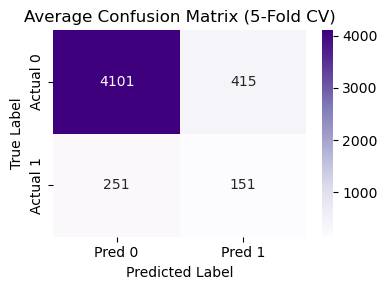

In [75]:
# Define best hyperparameters (from Optuna or manually copied)
best_params_cb = {
    'learning_rate': 0.011364915691807126,
    'depth': 9,
    'l2_leaf_reg': 8.08126346635858,
    'bootstrap_type': 'MVS',
    'iterations': 1000,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0
}

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
f1_scores = []
conf_matrices = []

y_full = pd.concat([y_train_catboost, y_test_catboost])
y_full = y_full.loc[X_catboost_full.index]  # ensure index alignment

# Start CV loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X_catboost_full, y_full), 1):
    X_tr, X_val = X_catboost_full.iloc[train_idx], X_catboost_full.iloc[test_idx]
    y_tr, y_val = y_full.iloc[train_idx], y_full.iloc[test_idx]

    model = CatBoostClassifier(**best_params_cb)
    model.fit(X_tr, y_tr)

    y_probs = model.predict_proba(X_val)[:, 1]
    y_preds = (y_probs > best_threshold_cb).astype(int)

    # Store metrics
    auc_scores.append(roc_auc_score(y_val, y_probs))
    f1_scores.append(f1_score(y_val, y_preds))
    conf_matrices.append(confusion_matrix(y_val, y_preds))

    print(f"Fold {fold} Confusion Matrix:\n{conf_matrices[-1]}\n")

# Average confusion matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)

# Final metrics
print(f"Cross-validated AUC: {np.mean(auc_scores):.4f}")
print(f"Cross-validated F1:  {np.mean(f1_scores):.4f}")
print(f"\nAverage Confusion Matrix Across Folds:\n{avg_conf_matrix}")

# Visualization
plt.figure(figsize=(4, 3))
sns.heatmap(avg_conf_matrix, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
plt.title("Average Confusion Matrix (5-Fold CV)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Conclusion and Next Steps
***

In this sample modeling notebook, we conducted a preliminary evaluation of several machine learning classifiers—Logistic Regression, Random Forest, XGBoost, LightGBM, and CatBoost—on a representative subset of the Home Credit Default Risk dataset. Our objective was to quickly assess model behavior, test the effectiveness of engineered features, and refine our modeling pipeline prior to scaling.

#### Key Takeaways from Sample Evaluation:
- CatBoostClassifier delivered the strongest overall results, achieving the highest AUC and recall after threshold tuning. Its native handling of categorical features and robust regularization made it well-suited for this tabular dataset.
- XGBoost and LightGBM were competitive in AUC but required more manual preprocessing and did not match CatBoost’s recall performance out of the box.
- Logistic Regression provided a useful linear baseline but underperformed in F1 and recall, suggesting limited ability to capture complex feature interactions.
- Random Forest offered decent performance but lacked the optimization granularity and recall sensitivity of boosting methods.

These results validate our modeling approach and establish a strong foundation for full-scale modeling.

We will now proceed to the full notebook, where we:
- Load and preprocess the complete training data, merging all 7 relational tables.
- Apply our finalized feature engineering pipeline, including over 500 features such as credit ratios, external risk scores, and time-based repayment behavior.
- Perform hyperparameter tuning with Optuna to maximize AUC, while prioritizing recall as the key business metric.
- Train the final CatBoost model on the full dataset using stratified K-Fold cross-validation.
- Interpret global and local model behavior using SHAP for transparency.
- Generate test set predictions and export a probability-based output for submission or deployment.

Continue to the Full Modeling Notebook for complete end-to-end training on the entire Home Credit dataset.
